In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import seaborn as sns
import pandas as pd

# 普通のガウス過程回帰

In [35]:

def calc_kernel_matrix(X, kernel):
    N = len(X)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel(X[i], X[j])

    return K

def calc_kernel_sequence(X, x, kernel):
    N = len(X)
    seq = np.zeros((N))
    for i in range(N):
        seq[i] = kernel(X[i], x)
        
    return seq


def predict(X_train, Y_train, X, kernel, sigma2_y):
    N = len(X)
    mu = np.zeros((N))
    sigma2 = np.zeros(N)
    N_train = len(Y_train)
    K = calc_kernel_matrix(X_train, kernel)
    invmat = np.linalg.inv(sigma2_y*np.eye(N_train) + K)
    
    for i in range(N):  
      seq = calc_kernel_sequence(X_train, X[i], kernel)
      mu[i] = (seq.reshape(1, N_train) @ invmat) @ Y_train
      sigma2[i] = np.sqrt(sigma2_y + kernel(X[i], X[i]) - (seq.reshape(1, N_train) @ invmat) @ seq.reshape(N_train, 1))

    return mu, sigma2

# ノイズありのガウス過程回帰（提案手法）

In [114]:
def calc_kernel_sequence_with_uncer(X, x, Uncer, uncer, kernel):
    N = len(X)
    seq = np.zeros((N))
    for i in range(N):
      seq[i] = kernel(X[i], x) + 0.5*(uncer[i] * Uncer)
        
    return seq

def calc_kernel_matrix_with_uncer(X, uncer, kernel):
    N = len(X)
    K = np.zeros((N, N))
    for i in range(N):
      for j in range(N):
        if i==j:
          K[i, j] = kernel(X[i], X[j]) + 0.5*(uncer[j] * uncer[i])
        else:
          K[i, j] = kernel(X[i], X[j]) + 0.5*(uncer[j] * uncer[i])

    return K

# def calc_kernel_matrix_with_uncer(X, uncer, kernel):
#     N = len(X)
#     K = np.zeros((N, N))
#     for i in range(N):
#       for j in range(N):
#         if i==j:
#           K[i, j] = kernel(X[i], X[j]) + 0.5
#         else:
#           K[i, j] = kernel(X[i], X[j])

#     return K

def predict_with_uncer(X_train, Y_train, X, uncer, Uncer, kernel, sigma2_y):
    N = len(X)
    mu = np.zeros((N))
    sigma2 = np.zeros(N)
    N_train = len(Y_train)
    K = calc_kernel_matrix_with_uncer(X_train, uncer, kernel)
    a = np.min(K)
    # K = K - a
    invmat = np.linalg.inv(sigma2_y*np.eye(N_train) + K)

    for i in range(N):
        
      seq = calc_kernel_sequence_with_uncer(X_train, X[i], Uncer, uncer, kernel)
      mu[i] = (seq.reshape(1, N_train) @ invmat) @ Y_train
      sigma2[i] = sigma2_y + kernel(X[i], X[i]) + 0.2*Uncer - (seq.reshape(1, N_train) @ invmat) @ seq.reshape(N_train, 1)
        
        
    return mu, sigma2

In [115]:
np.random.seed(0)
resolution = 10
x_train = np.sort(np.random.rand(resolution)*20)
noise = np.random.randn(len(x_train))*0.5
y_train = np.sin(x_train) + noise*0.5

In [116]:
x_test = np.arange(0, 20, 0.2)
y = np.sin(x_test)

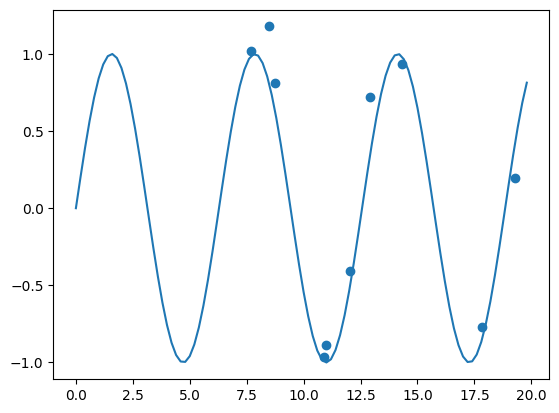

In [117]:
plt.scatter(x_train,y_train)
plt.plot(x_test, y)

In [118]:
alpha = 1.2
beta = 0.5
kernel_g = lambda x1, x2: alpha * np.exp(-0.5*(beta**2)*np.linalg.norm(x1 - x2))
sigma2_y = 0.01

# ノイズありの共分散行列

<AxesSubplot: >

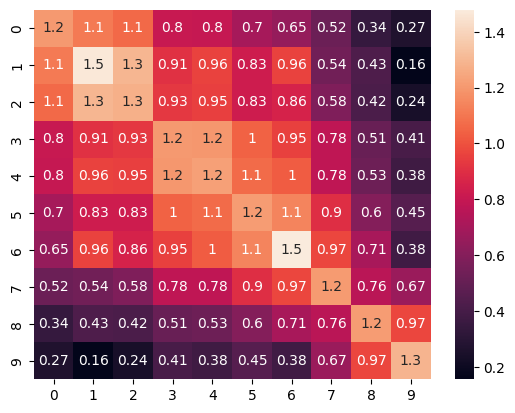

In [119]:
sigma2_y = 0
N_train = len(noise)
K = calc_kernel_matrix_with_uncer(x_train, noise, kernel_g)
invmat = np.linalg.inv(sigma2_y*np.eye(N_train) + K)
# seq = calc_kernel_sequence_with_uncer(x_train, x_test[70], 0, noise, kernel_g)
plt.figure()
sns.heatmap(K, annot=True)

# ノイズなしの共分散行列

<AxesSubplot: >

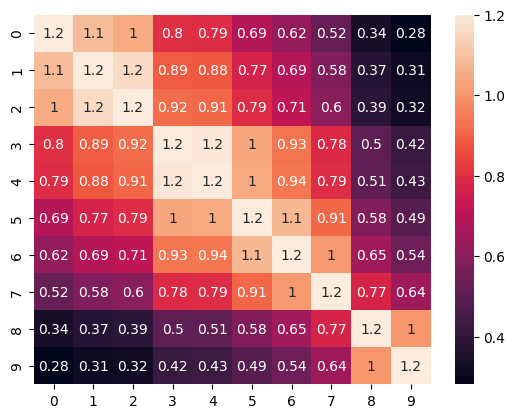

In [120]:
K = calc_kernel_matrix(x_train, kernel_g)
invmat = np.linalg.inv(sigma2_y*np.eye(N_train) + K)
plt.figure()
sns.heatmap(K, annot=True)

In [121]:
noise

array([ 0.07202179,  0.72713675,  0.38051886,  0.06083751,  0.22193162,
        0.16683716,  0.74703954, -0.10257913,  0.15653385, -0.42704787])

In [122]:
mu_g, std_g = predict_with_uncer(x_train, y_train, x_test, np.abs(noise), 0, kernel_g, sigma2_y)
mu, std = predict(x_train, y_train, x_test, kernel_g, sigma2_y)

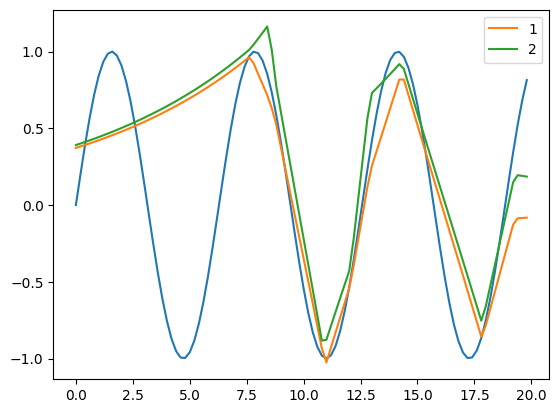

In [123]:
plt.plot(x_test, y)
plt.plot(x_test, mu_g, label='1')
plt.plot(x_test, mu, label='2')
plt.legend()

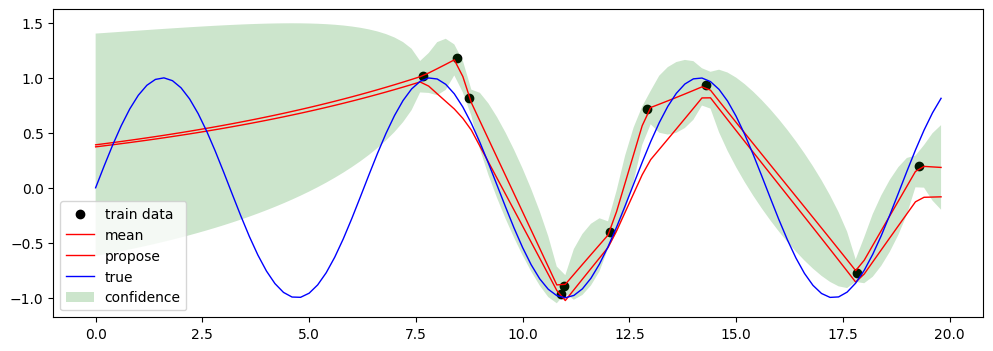

In [124]:
fig = plt.figure(figsize=(12, 4))
plt.cla()
plt.scatter(x_train, y_train, c="black", marker="o", label="train data")
plt.plot(x_test, mu, color="red", linewidth=1, label="mean")
plt.plot(x_test, mu_g, color="red", linewidth=1, label="propose")
plt.plot(x_test, y, color="blue", linewidth=1, label="true")
plt.fill_between(x_test, mu + std, mu - std, facecolor='green', alpha=0.2, label="confidence")
plt.legend()
plt.show()

# 線形回帰

In [125]:
x_train =np.arange(1, 20, 3)
x_train = np.array([ 1,  4, 10, 16, 19])
x_train1 = np.array([ 1,  4, 16, 19])

y_train = 0.5*x_train
y_train1 = 0.5*x_train1

noise = np.array([0.1, 0.1, 0.8, 0.1, 0.1])
x_test = np.arange(0, 20, 0.2)
y = 0.5*x_test

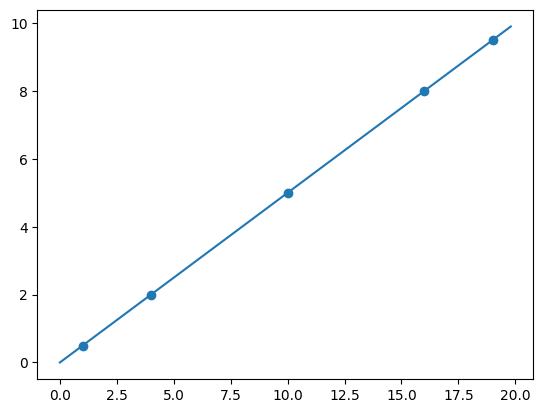

In [126]:
plt.plot(x_test, y)
plt.scatter(x_train, y_train)

In [127]:
alpha = 1.2
beta = 0.5
kernel_g = lambda x1, x2: alpha * np.exp(-0.5*(beta**2)*np.linalg.norm(x1 - x2))
sigma2_y = 0.01
mu_g, std_g = predict_with_uncer(x_train, y_train, x_test, noise, 0, kernel_g, sigma2_y)
mu, std = predict(x_train, y_train, x_test, kernel_g, sigma2_y)

In [128]:
mu1, std1 = predict(x_train1, y_train1, x_test, kernel_g, sigma2_y)
# mu1, std1 = gpr_with_noise(x_test, x_train, y_train, kernel_g)

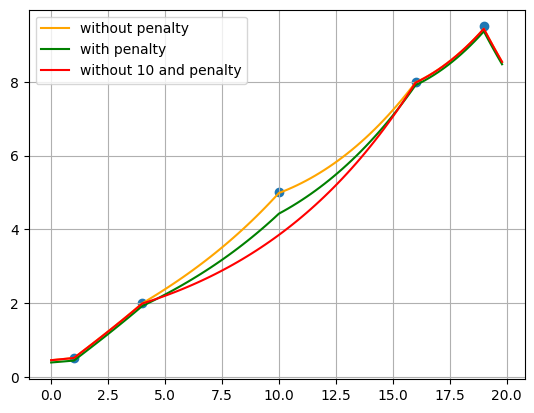

In [129]:
# plt.plot(x_test, y, label='true')
plt.plot(x_test, mu, c='orange', label='without penalty')
plt.plot(x_test, mu_g, c='green', label='with penalty')
plt.plot(x_test, mu1, c='red', label='without 10 and penalty')
plt.scatter(x_train, y_train)
plt.legend()
plt.grid()

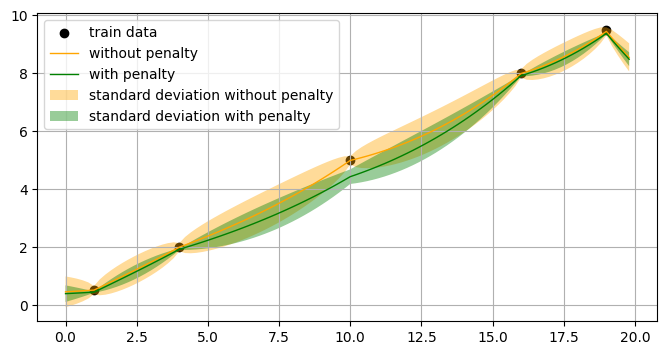

In [130]:
fig = plt.figure(figsize=(8, 4))
plt.cla()
plt.scatter(x_train, y_train, c="black", marker="o", label="train data")

# plt.plot(x_test, y, linewidth=1, label="true")

plt.plot(x_test, mu, linewidth=1,  c='orange', label="without penalty")
# plt.plot(x_test, mu1, linewidth=1, label="without 10")
plt.plot(x_test, mu_g, linewidth=1, c='green', label="with penalty")

# plt.fill_between(x_test, mu1 + std1, mu1 - std1, alpha=0.2, label="confidence without 10")
plt.fill_between(x_test, mu + std, mu - std, facecolor='orange', alpha=0.4, label="standard deviation without penalty")
plt.fill_between(x_test, mu_g + std_g, mu_g - std_g, facecolor='green', alpha=0.4, label="standard deviation with penalty")
plt.legend(loc='upper left')
plt.grid()
plt.show()

# sin波回帰

In [161]:
np.random.seed(0)
resolution = 30
x_train = np.sort(np.random.rand(resolution)*20)[:20]
noise = np.random.rand(len(x_train))
y_train = np.sin(x_train) #+ noise*0.5

x_test = np.arange(0, 20, 0.2)
y = np.sin(x_test)

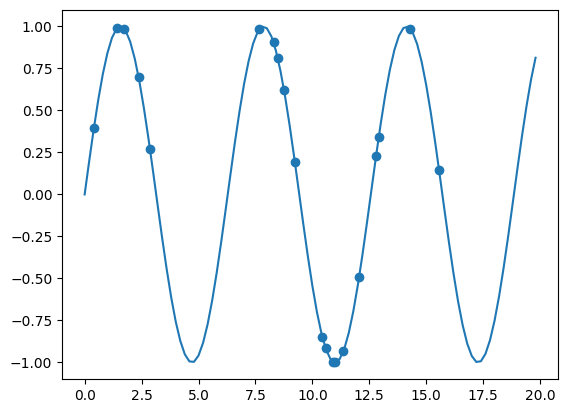

In [162]:
plt.plot(x_test, y)
plt.scatter(x_train, y_train)

In [163]:
alpha = 1.2
beta = 0.5
kernel_g = lambda x1, x2: alpha * np.exp(-0.5*(beta**2)*np.linalg.norm(x1 - x2))
sigma2_y = 0.01
mu_g, std_g = predict_with_uncer(x_train, y_train, x_test, noise, 0, kernel_g, sigma2_y)
mu, std = predict(x_train, y_train, x_test, kernel_g, sigma2_y)

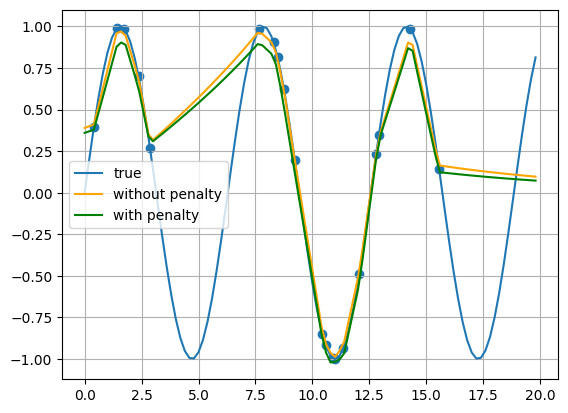

In [164]:
plt.plot(x_test, y, label='true')
plt.plot(x_test, mu, c='orange', label='without penalty')
plt.plot(x_test, mu_g, c='green', label='with penalty')
# plt.plot(x_test, mu1, c='red', label='without 10 and penalty')
plt.scatter(x_train, y_train)
plt.legend()
plt.grid()

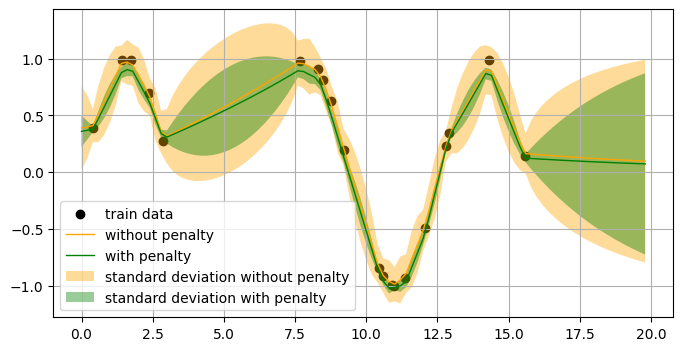

In [165]:
fig = plt.figure(figsize=(8, 4))
plt.cla()
plt.scatter(x_train, y_train, c="black", marker="o", label="train data")

# plt.plot(x_test, y, linewidth=1, label="true")

plt.plot(x_test, mu, linewidth=1,  c='orange', label="without penalty")
# plt.plot(x_test, mu1, linewidth=1, label="without 10")
plt.plot(x_test, mu_g, linewidth=1, c='green', label="with penalty")

# plt.fill_between(x_test, mu1 + std1, mu1 - std1, alpha=0.2, label="confidence without 10")
plt.fill_between(x_test, mu + std, mu - std, facecolor='orange', alpha=0.4, label="standard deviation without penalty")
plt.fill_between(x_test, mu_g + std_g, mu_g - std_g, facecolor='green', alpha=0.4, label="standard deviation with penalty")
plt.legend()
plt.grid()
plt.show()

# ノイズを単調増加にしたら

In [167]:
noise = np.array(list(range(30)))*0.05

np.random.seed(0)
resolution = 30
x_train = np.sort(np.random.rand(resolution)*20)[:20]

y_train = np.sin(x_train) #+ noise*0.5

x_test = np.arange(0, 20, 0.2)
y = np.sin(x_test)

In [168]:
alpha = 1.2
beta = 0.5
kernel_g = lambda x1, x2: alpha * np.exp(-0.5*(beta**2)*np.linalg.norm(x1 - x2))
sigma2_y = 0.01
mu_g, std_g = predict_with_uncer(x_train, y_train, x_test, noise, 0, kernel_g, sigma2_y)
mu, std = predict(x_train, y_train, x_test, kernel_g, sigma2_y)

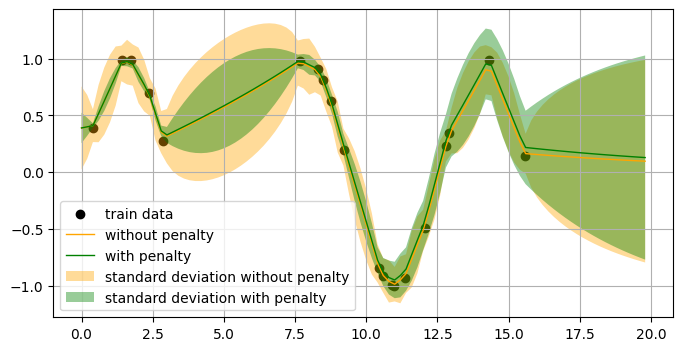

In [169]:
fig = plt.figure(figsize=(8, 4))
plt.cla()
plt.scatter(x_train, y_train, c="black", marker="o", label="train data")

# plt.plot(x_test, y, linewidth=1, label="true")

plt.plot(x_test, mu, linewidth=1,  c='orange', label="without penalty")
# plt.plot(x_test, mu1, linewidth=1, label="without 10")
plt.plot(x_test, mu_g, linewidth=1, c='green', label="with penalty")

# plt.fill_between(x_test, mu1 + std1, mu1 - std1, alpha=0.2, label="confidence without 10")
plt.fill_between(x_test, mu + std, mu - std, facecolor='orange', alpha=0.4, label="standard deviation without penalty")
plt.fill_between(x_test, mu_g + std_g, mu_g - std_g, facecolor='green', alpha=0.4, label="standard deviation with penalty")
plt.legend()
plt.grid()
plt.show()